### Moran-Felsenszwalb tissue domain segmentation workflow

Note that a more computationally efficient implementation of the Moran-Felsenszwalb workflow is available. 

In [1]:
import pickle
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 
from skimage.segmentation import felzenszwalb, mark_boundaries
from sklearn.preprocessing import minmax_scale
from skimage.measure import label
from sklearn.cluster import KMeans
from scipy import stats

In [2]:
from moran_imaging.spatial_weights_matrix import define_spatial_weights_matrix
from moran_imaging.local_global_spatial_autocorrelation import MoranLocal
from moran_imaging.plotting import position_discrete_colorbar_ticks

In [3]:
# Fix random seed
random.seed(0)

# Seaborn plotting style
sns.set(style="whitegrid", font_scale=1)

# Define colormap for Moran quadrant maps
colormap_reverse = sns.blend_palette([".99", "darkblue"], as_cmap=True)
colormap_scatterplot = ListedColormap(['#ff85a5', 'black', 'lightskyblue', 'white'])
colormap_scatterplot_binary = ListedColormap(['#ff85a5', 'lightskyblue'])

# Define colormap for segmentation map
num_clusters = 15
num_viridis = int(np.floor(num_clusters/2))
num_coolwarm = int(num_clusters - num_viridis)
viridis = plt.cm.get_cmap('viridis_r', num_viridis) 
coolwarm = sns.color_palette('coolwarm_r', as_cmap=True)(np.linspace(0, 1, num_coolwarm))
combined_colors = np.vstack([viridis(np.linspace(0, 1, num_viridis)), coolwarm])
combined_cmap = ListedColormap(combined_colors)

C:\Users\Leo\AppData\Local\Temp\ipykernel_35544\2868187681.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis_r', num_viridis)


In [4]:
def make_ion_image(data, image_shape, background_mask, fill_zeros=True, show_image=True, colormap='viridis'):
    
    # Fill background pixels with zeros (default) or NaN
    pixel_grid = np.zeros((image_shape[0]*image_shape[1], ))
    pixel_grid[np.invert(background_mask)] = data
    
    if not fill_zeros:
        pixel_grid[background_mask] = np.nan
    
    # Reshape data
    ion_image = np.reshape(pixel_grid, image_shape)
    
    # Plot ion image 
    if show_image == True: 
        plt.figure(dpi=100)
        plt.imshow(ion_image, cmap=colormap)
        plt.axis('off')
        plt.show()
        
    return ion_image

In [5]:
def kmeans_superpixel_coloring(segments, cluster_labels, num_pixels, background_mask): 
    
    segmentation_labels = label(segments).flatten()[np.invert(background_mask)]
    mapping_pixel_to_segment = segmentation_labels
    all_segment_labels = np.unique(mapping_pixel_to_segment)
    dict_segment_to_pixels = {}
    for segment_label in all_segment_labels: 
        dict_segment_to_pixels[segment_label] = mapping_pixel_to_segment == segment_label

    segment_label_dict = {}
    for segment_label in all_segment_labels: 
        mask_segment = dict_segment_to_pixels[segment_label]
        pixel_labels_segment = cluster_labels[mask_segment]
        cluster_segment_label = stats.mode(pixel_labels_segment)[0]
        segment_label_dict[segment_label] = cluster_segment_label

    final_cluster_labels = np.zeros(num_pixels)
    for segment_label in all_segment_labels: 
        mask_segment = dict_segment_to_pixels[segment_label]
        final_cluster_labels[mask_segment] = segment_label_dict[segment_label]
        
    return final_cluster_labels

#### Load imaging mass spectrometry data

In [6]:
with open('./Zebra_fish_UMAP_dataset.pickle', 'rb') as handle:
    zebra_fish_dict = pickle.load(handle)

image_shape = zebra_fish_dict['image_shape'] 
background_mask = zebra_fish_dict['background_mask'] 
pixel_order = zebra_fish_dict['pixel_order']  
dataset_UMAP = zebra_fish_dict['dataset_UMAP'] 
acquisition_mask = np.invert(background_mask)
num_pixels = dataset_UMAP.shape[0]

#### Moran quadrant map computation

In [7]:
# Definition of the spatial weights matrix
weights_matrix = define_spatial_weights_matrix(image_shape, 'Queen', 5, background_mask, with_lower_order=True)
weights_matrix.transform = "r"

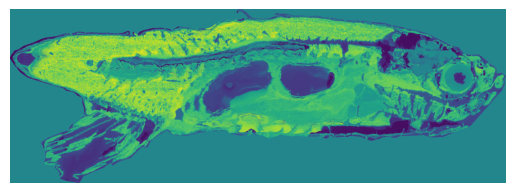

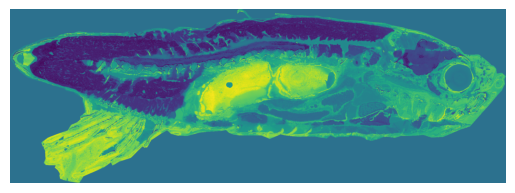

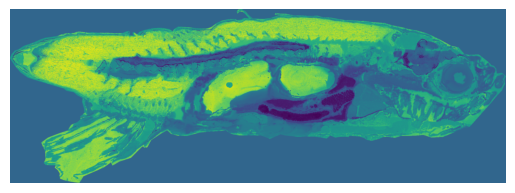

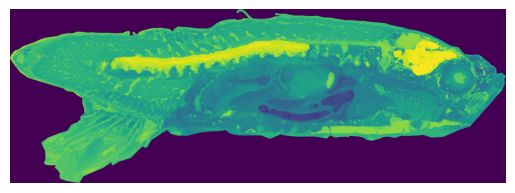

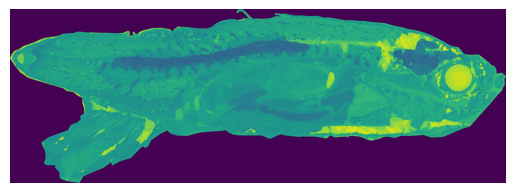

In [8]:
# Computation of one Moran quadrant map per UMAP feature
Dict_Moran_quadrants = {}

ion_image_with_background_PC1 = make_ion_image(dataset_UMAP[:, 0], image_shape, background_mask, fill_zeros=True)
local_Moran_object_PC1 = MoranLocal(ion_image_with_background_PC1.astype("float64"), weights_matrix, background_mask, 999, 52)
Moran_quadrants_PC1 = local_Moran_object_PC1.quadrant.astype(float)
Dict_Moran_quadrants[0] = Moran_quadrants_PC1[acquisition_mask]

ion_image_with_background_PC2 = make_ion_image(dataset_UMAP[:, 1], image_shape, background_mask, fill_zeros=True)
local_Moran_object_PC2 = MoranLocal(ion_image_with_background_PC2.astype("float64"), weights_matrix, background_mask, 999, 52)
Moran_quadrants_PC2 = local_Moran_object_PC2.quadrant.astype(float)
Dict_Moran_quadrants[1] = Moran_quadrants_PC2[acquisition_mask]

ion_image_with_background_PC3 = make_ion_image(dataset_UMAP[:, 2], image_shape, background_mask, fill_zeros=True)
local_Moran_object_PC3 = MoranLocal(ion_image_with_background_PC3.astype("float64"), weights_matrix, background_mask, 999, 52)
Moran_quadrants_PC3 = local_Moran_object_PC3.quadrant.astype(float)
Dict_Moran_quadrants[2] = Moran_quadrants_PC3[acquisition_mask]

ion_image_with_background_PC4 = make_ion_image(dataset_UMAP[:, 4], image_shape, background_mask, fill_zeros=True)
local_Moran_object_PC4 = MoranLocal(ion_image_with_background_PC4.astype("float64"), weights_matrix, background_mask, 999, 52)
Moran_quadrants_PC4 = local_Moran_object_PC4.quadrant.astype(float)
Dict_Moran_quadrants[3] = Moran_quadrants_PC4[acquisition_mask]

ion_image_with_background_PC5 = make_ion_image(dataset_UMAP[:, 7], image_shape, background_mask, fill_zeros=True)
local_Moran_object_PC5 = MoranLocal(ion_image_with_background_PC5.astype("float64"), weights_matrix, background_mask, 999, 52)
Moran_quadrants_PC5 = local_Moran_object_PC5.quadrant.astype(float)
Dict_Moran_quadrants[4] = Moran_quadrants_PC5[acquisition_mask]

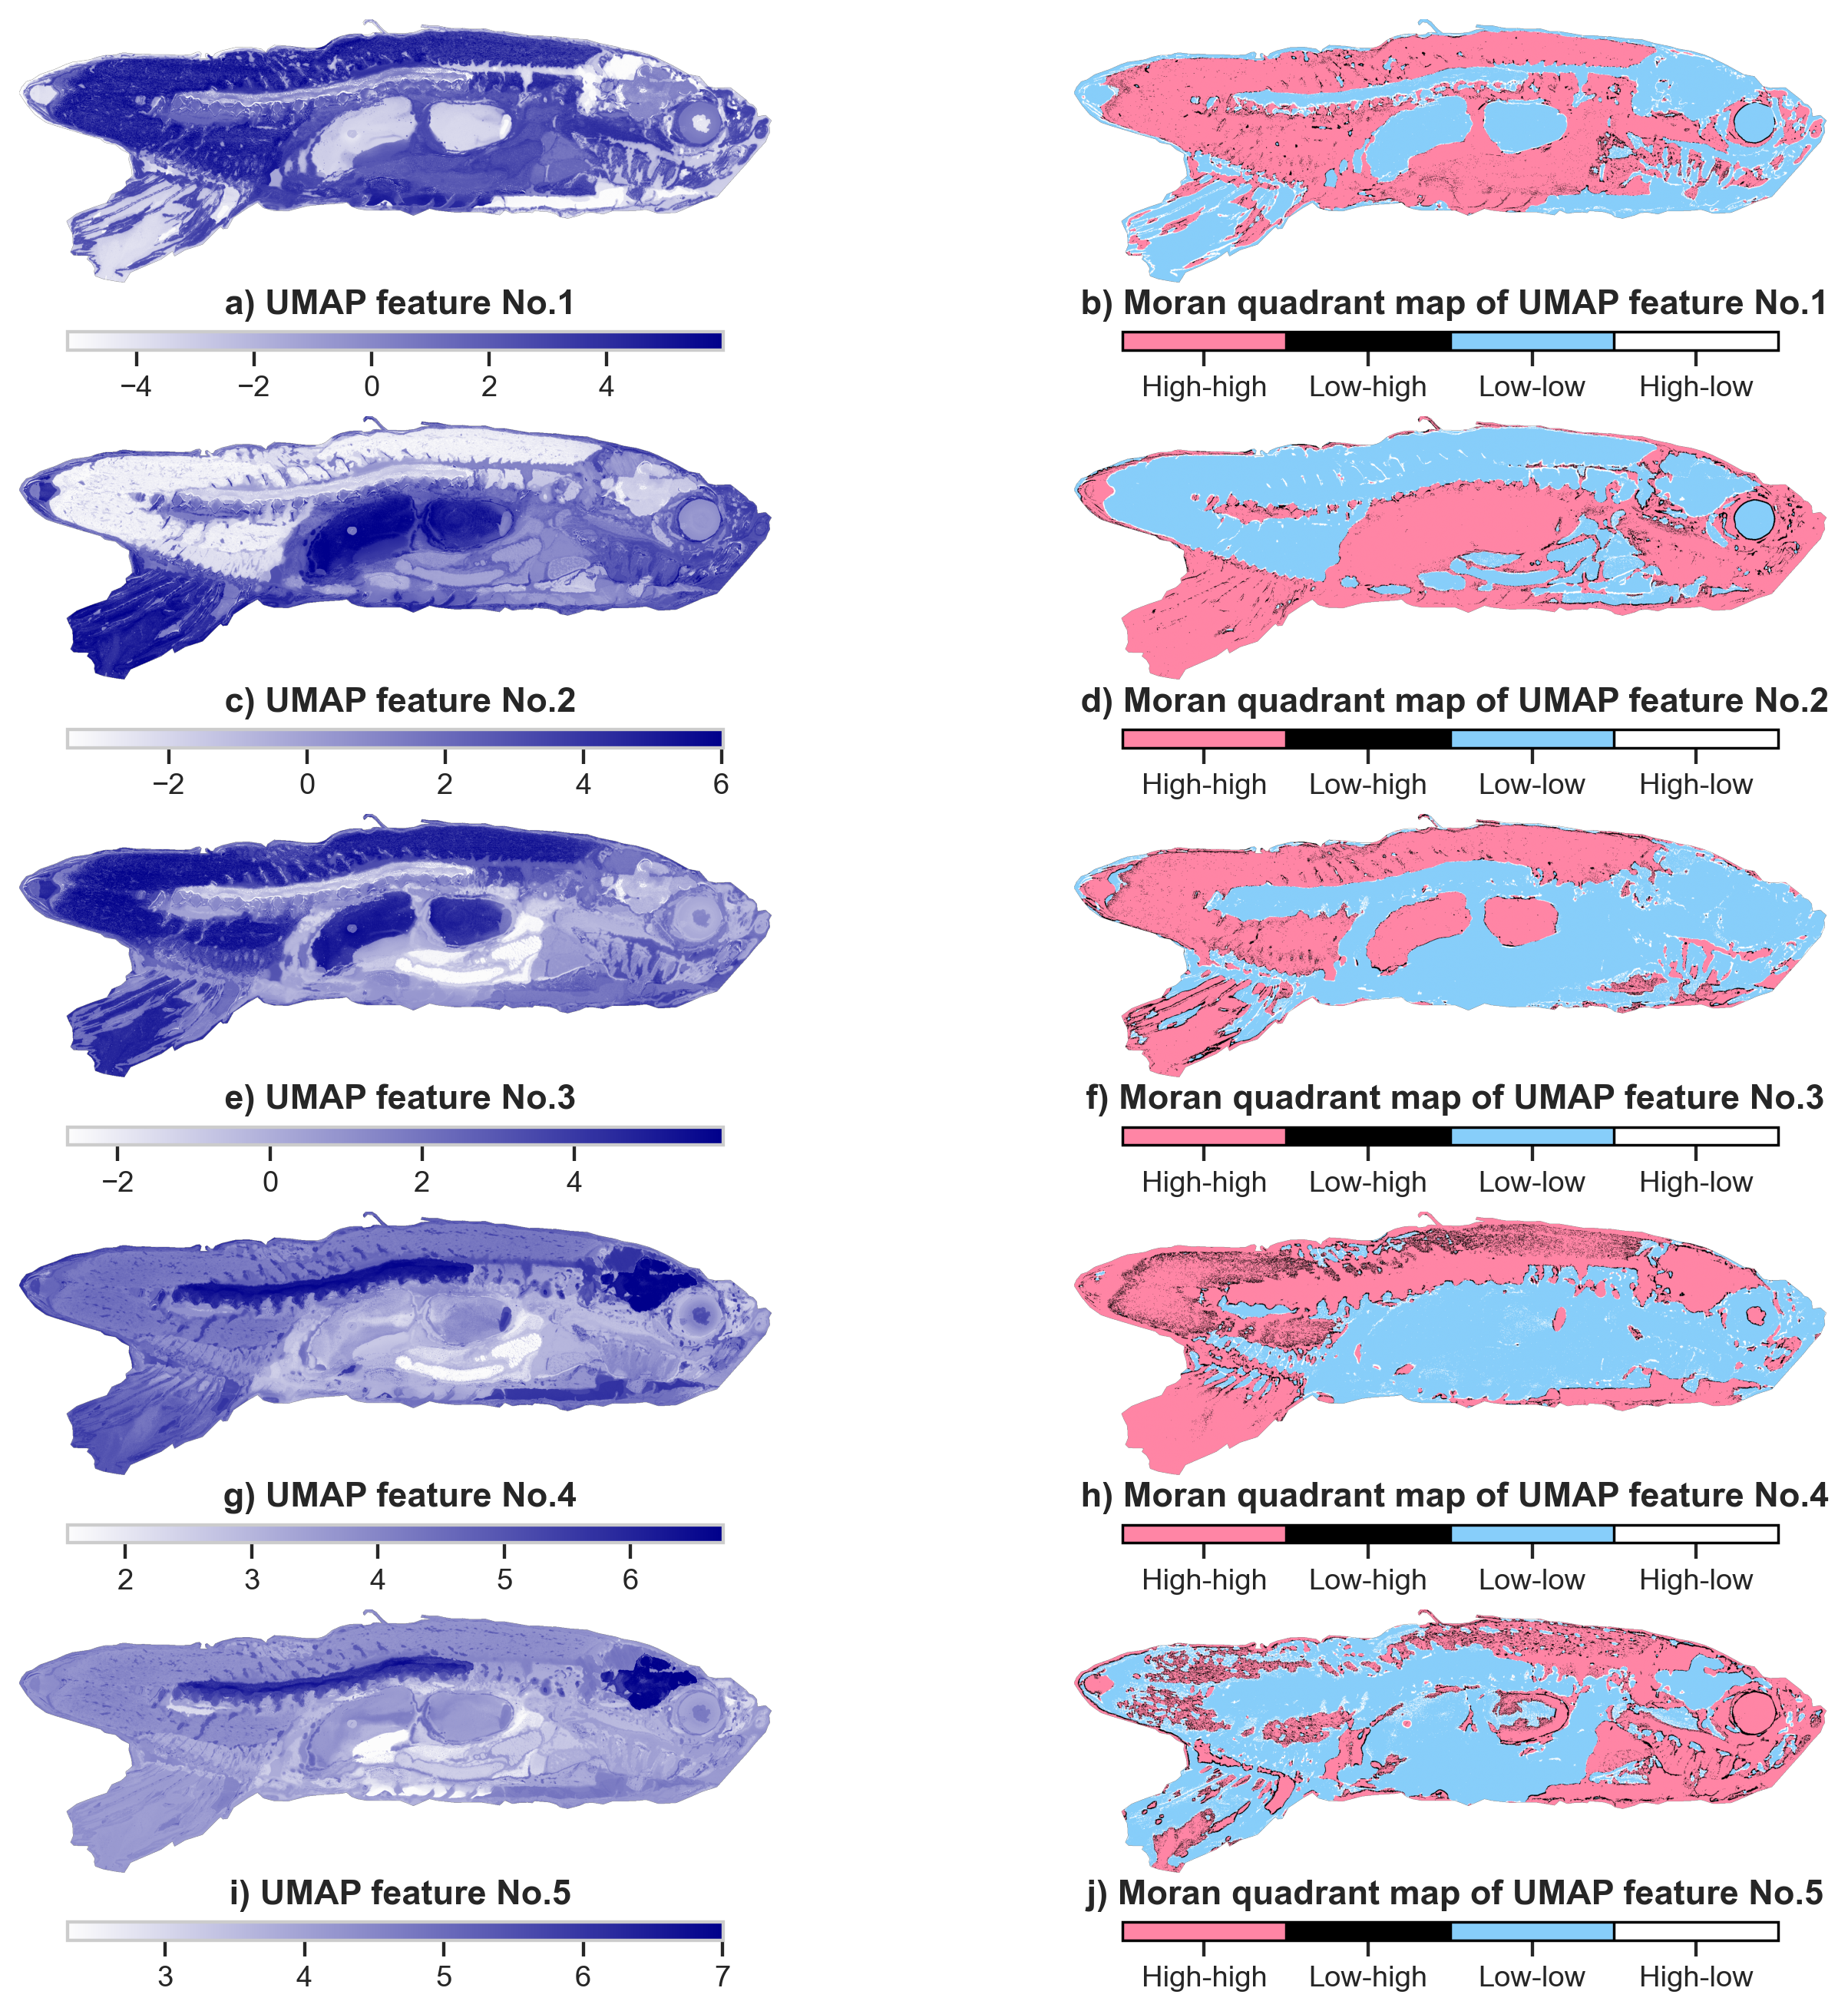

In [9]:
demo_list = [0, 1, 2, 3, 4]
fig = plt.figure(figsize=(13, 13), dpi=250)
dataset_UMAP_mini = dataset_UMAP[:, [0, 1, 2, 4, 5]]
gridspec = plt.GridSpec(5, 2)
plt.tight_layout()

for ax_index, feature_index in enumerate(demo_list):
    letters = ["a", "c", "e", "g", "i"]
    axes_mini = fig.add_subplot(gridspec[ax_index, 0])
    ion_image = make_ion_image(dataset_UMAP_mini[:, feature_index], image_shape, background_mask, fill_zeros=False, show_image=False)
    
    mini_fig = axes_mini.imshow(ion_image, vmin=np.nanpercentile(ion_image, 1), vmax=np.nanpercentile(ion_image, 99), cmap=colormap_reverse)
    axes_mini.set_title("\n " + letters[ax_index] + ") UMAP feature No." + str(feature_index+1), y=-0.18, fontsize=13, fontweight="bold")
    axes_mini.axis("off")
    cbar = fig.colorbar(mini_fig, ax=axes_mini, orientation="horizontal", fraction=0.055, pad=0.15, aspect=36)
    #cbar.set_label("UMAP feature intensity")
    cbar.ax.tick_params()

for ax_index, feature_index in enumerate(demo_list):
    letters = ["b", "d", "f", "h", "j"]
    axes_mini = fig.add_subplot(gridspec[ax_index, 1])
    Moran_quadrants = Dict_Moran_quadrants[feature_index]
    Moran_quadrant_map = make_ion_image(Moran_quadrants, image_shape, background_mask, fill_zeros=False, show_image=False) 
    
    mini_fig = axes_mini.imshow(Moran_quadrant_map, cmap=colormap_scatterplot, interpolation=None) 
    axes_mini.set_title("\n " + letters[ax_index] + ") Moran quadrant map of UMAP feature No." + str(feature_index+1), y=-0.18, fontsize=13, fontweight="bold")
    axes_mini.axis("off")
    
    tick_labels = ['High-high', 'Low-high', 'Low-low', 'High-low']
    tick_loc = position_discrete_colorbar_ticks(1, 4)
    cbar_total = plt.colorbar(mini_fig, ax=axes_mini, ticks=tick_loc, orientation='horizontal', fraction=0.055, pad=0.15, aspect=36, drawedges=True)
    cbar_total.ax.set_xticklabels(tick_labels)
    cbar_total.outline.set_color('black')
    cbar_total.dividers.set_color('black')
    cbar_total.dividers.set_linewidth(1)
    cbar_total.outline.set_linewidth(1)
plt.show()

#### Felsenszwalb segmentation for super-pixel definition

In [10]:
PCs_like_RGB = np.zeros((image_shape[0], image_shape[1], 5))
PCs_like_RGB[:, :, 0] = make_ion_image(Dict_Moran_quadrants[0], image_shape, background_mask, fill_zeros=False, show_image=False) 
PCs_like_RGB[:, :, 1] = make_ion_image(Dict_Moran_quadrants[1], image_shape, background_mask, fill_zeros=False, show_image=False) 
PCs_like_RGB[:, :, 2] = make_ion_image(Dict_Moran_quadrants[2], image_shape, background_mask, fill_zeros=False, show_image=False) 
PCs_like_RGB[:, :, 3] = make_ion_image(Dict_Moran_quadrants[3], image_shape, background_mask, fill_zeros=False, show_image=False) 
PCs_like_RGB[:, :, 4] = make_ion_image(Dict_Moran_quadrants[4], image_shape, background_mask, fill_zeros=False, show_image=False) 

segments_moran = felzenszwalb(PCs_like_RGB, scale=40, sigma=0.2, min_size=80)
segments_moran_flat = segments_moran.flatten()[acquisition_mask]

C:\Users\Leo\AppData\Local\Temp\ipykernel_35544\1309438003.py:8: RuntimeWarning: Got image with third dimension of 5. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments_moran = felzenszwalb(PCs_like_RGB, scale=40, sigma=0.2, min_size=80)


In [11]:
baseline_image = np.zeros((image_shape[0], image_shape[1], 4), dtype=np.float32)
UMAP1_scale = minmax_scale(dataset_UMAP[:, 0], feature_range=(0, 1))
UMAP2_scale = minmax_scale(dataset_UMAP[:, 1], feature_range=(0, 1))
UMAP3_scale = minmax_scale(dataset_UMAP[:, 2], feature_range=(0, 1))
UMAP4_scale = minmax_scale(dataset_UMAP[:, 3], feature_range=(0, 1))
baseline_image[:, :, 0] = make_ion_image(UMAP1_scale, image_shape, background_mask, fill_zeros=False, show_image=False) 
baseline_image[:, :, 1] = make_ion_image(UMAP2_scale, image_shape, background_mask, fill_zeros=False, show_image=False)
baseline_image[:, :, 2] = make_ion_image(UMAP3_scale, image_shape, background_mask, fill_zeros=False, show_image=False)

segmentation_boundaries = mark_boundaries(baseline_image[:, :, 0], segments_moran)
spatial_segmentation_boundaries_no_background = np.zeros(segmentation_boundaries.shape)
spatial_segmentation_boundaries_no_background[:, :, 0] = make_ion_image(segmentation_boundaries[:, :, 0].flatten()[acquisition_mask], image_shape, background_mask, fill_zeros=False, show_image=False)
spatial_segmentation_boundaries_no_background[:, :, 1] = make_ion_image(segmentation_boundaries[:, :, 1].flatten()[acquisition_mask], image_shape, background_mask, fill_zeros=False, show_image=False)
spatial_segmentation_boundaries_no_background[:, :, 2] = make_ion_image(segmentation_boundaries[:, :, 2].flatten()[acquisition_mask], image_shape, background_mask, fill_zeros=False, show_image=False)

#### k-means clustering with k=15 for super-pixel labeling

In [12]:
cluster_model = KMeans(n_clusters=num_clusters, init='k-means++', n_init='auto', random_state=1)
cluster_model.fit(dataset_UMAP)
cluster_labels = cluster_model.labels_

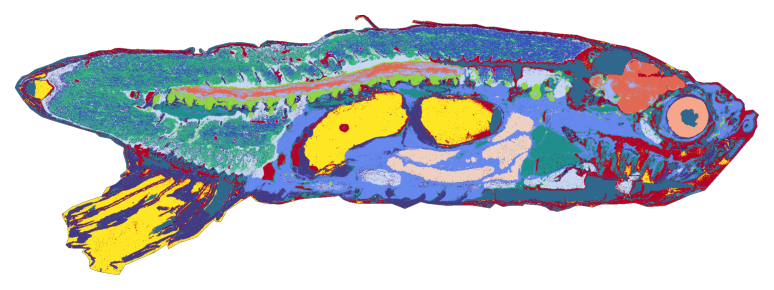

In [13]:
# Plot clustering results
pixel_grid = np.zeros((image_shape[0]*image_shape[1], ))
pixel_grid[np.invert(background_mask)] = cluster_labels
pixel_grid[background_mask] = np.nan
kmeans_cluster_image = np.reshape(pixel_grid, image_shape)
plt.figure(dpi=150)
plt.imshow(kmeans_cluster_image, cmap=combined_cmap)
plt.axis('off')
plt.show()

#### Moran-Felsenszwalb segmentation results

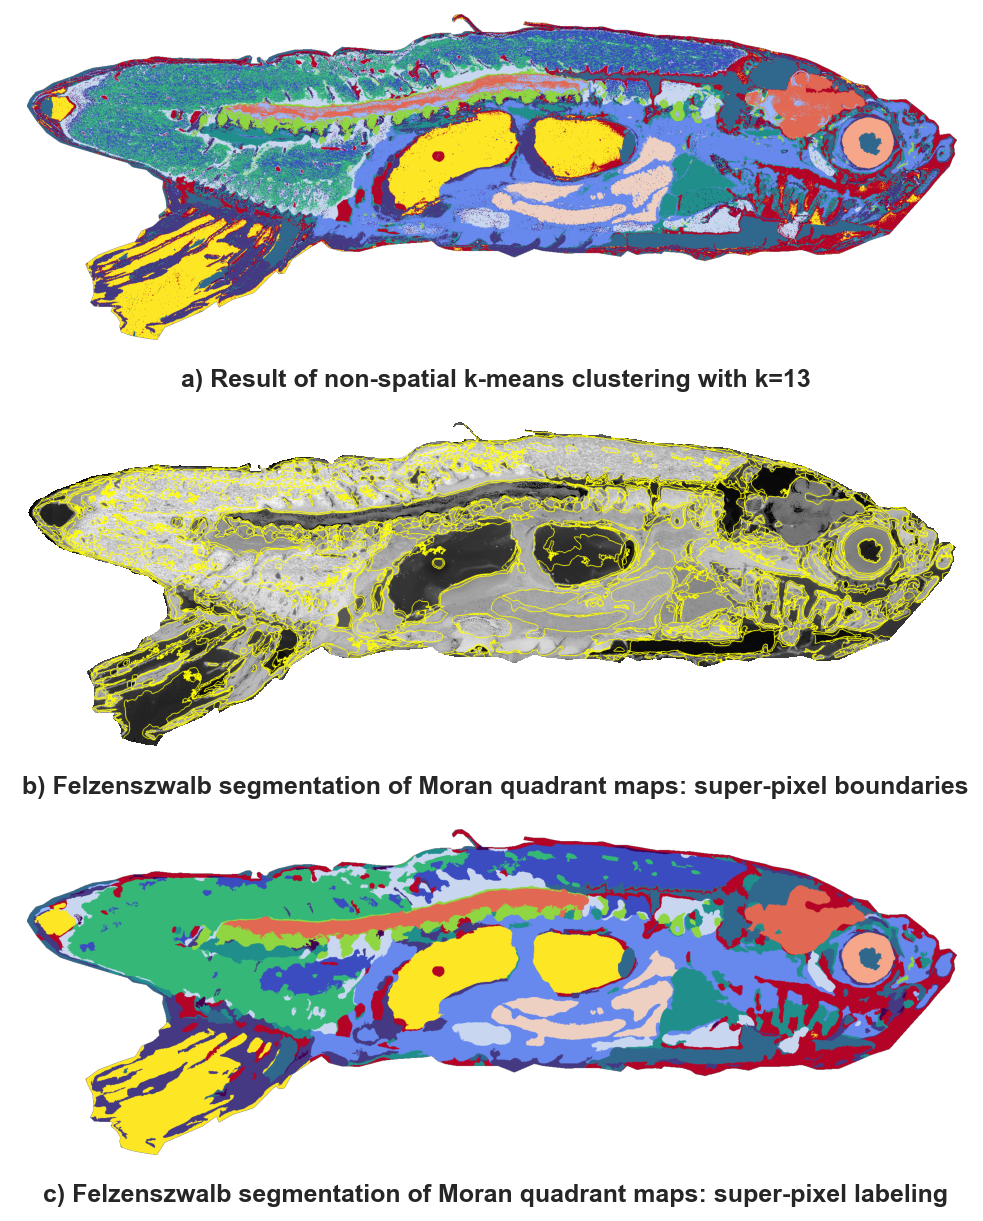

In [14]:
segment_method = 'felzenszwalb'
fig = plt.figure(figsize=(8, 10), dpi=150)
gridspec = plt.GridSpec(3, 1)
plt.tight_layout()

axes_mini = fig.add_subplot(gridspec[0])
mini_fig = axes_mini.imshow(kmeans_cluster_image, cmap=combined_cmap)
axes_mini.set_title("\n a) Result of non-spatial k-means clustering with k=13", y=-0.18, fontsize=12, fontweight="bold")
axes_mini.axis("off")

axes_mini = fig.add_subplot(gridspec[1])
mini_fig = axes_mini.imshow(spatial_segmentation_boundaries_no_background, interpolation=None, cmap='Greys')
axes_mini.set_title("\n b) " + segment_method.title() + " segmentation of Moran quadrant maps: super-pixel boundaries", y=-0.18, fontsize=12, fontweight="bold")
axes_mini.axis("off")

axes_mini = fig.add_subplot(gridspec[2])
final_cluster_labels_spatial = kmeans_superpixel_coloring(segments_moran, cluster_labels, num_pixels, background_mask)
final_cluster_labels_spatial = make_ion_image(final_cluster_labels_spatial, image_shape, background_mask, fill_zeros=False, show_image=False)
mini_fig = axes_mini.imshow(final_cluster_labels_spatial, cmap=combined_cmap)
axes_mini.set_title("\n c) " + segment_method.title() + " segmentation of Moran quadrant maps: super-pixel labeling", y=-0.18, fontsize=12, fontweight="bold")
axes_mini.axis("off")

plt.show()